# Pokémon images classification challenge: Task 3

## 1. Previously

- Introduction
- EDA (Exploratory Data Analysis) of the dataset
- pre-processing of the data
- classification using an MLP (Multilayer Perceptron).

This work is available at this link: https://drive.google.com/file/d/1fci5SJnuwGc3tGgtzdE0X4BfafhX83B3/view?usp=sharing

- classification using a CNN (Convolutional Neural Network)

This work is available at this link: https://colab.research.google.com/drive/1K5vKpp7Ao14shwvcM5goHyPJUYs0mnUK?usp=sharing

In this notebook, we perform a classification using **Transfer Learning and Fine-Tuning**. The dataset consists of **images of Pokémon**, each identified by an ID (corresponding to an image file with png extension) and a label indicating its **type**.

**NOTE:** The images contained in the dataset for this task are different from those for the previous tasks. You can have further information on this new dataset in this notebook: https://drive.google.com/file/d/1Lst5X_eiEN9P18NgoabYBPUZ5JWtzpwl/view?usp=sharing.
Moreover, for the presentation we need to use a CNN from scratch on our new dataset: https://drive.google.com/file/d/1i4TQAcRYQ2TQsiTdrGAN_55jrLmXoz5d/view?usp=sharing, this notebook presents the CNN from scratch (it is basically the one from Task 2 withtout our fonction to remove the background and center pokémon because it can not be used with this new dataset).

## 2. Setting up the environnement and the data

### Librairies importation

In [ ]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torch.utils.data import DataLoader, Dataset, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

import random

### Data location

In [ ]:
# #use of google drive to import data
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# ! ls drive/MyDrive/AP_Assignement1_Task3

 databricks.txt
'For the presentation.gdoc'
'GALLO - LEKBOURI - LICHTNER - WERCK - Slides_DL_A1_task3.pptx'
 New_EDA.ipynb
 Task3.ipynb
 Test
 Train
 train_labels.csv


In [ ]:
#choosing the path where the dataset is stocked

# # Google Colab
# my_path = 'drive/MyDrive/AP_Assignement1_Task3/'

# Local
my_path = '../data'

## 3. Data preprocessing and MLFLow

### Data Load

In [ ]:
# Load labels
data_path = my_path +"train_labels_task3.csv"
image_folder = my_path +"Train_task3"
labels_df = pd.read_csv(data_path)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
labels_df['encoded_label'] = label_encoder.fit_transform(labels_df['label'])

In [ ]:
# Train-validation split
train_df, val_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['label'], random_state=42)

In [ ]:
# Data augmentation and regularization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


When using pre-trained models, it's best to normalize images with ImageNet statistics:

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

This keeps the input distribution aligned with what the model expects, ensuring better transfer learning performance. Using our custom dataset stats is only recommended when training from scratch (what we did before: mean = [0.4464, 0.4480, 0.4158],std = [0.1823, 0.1728, 0.1813]).

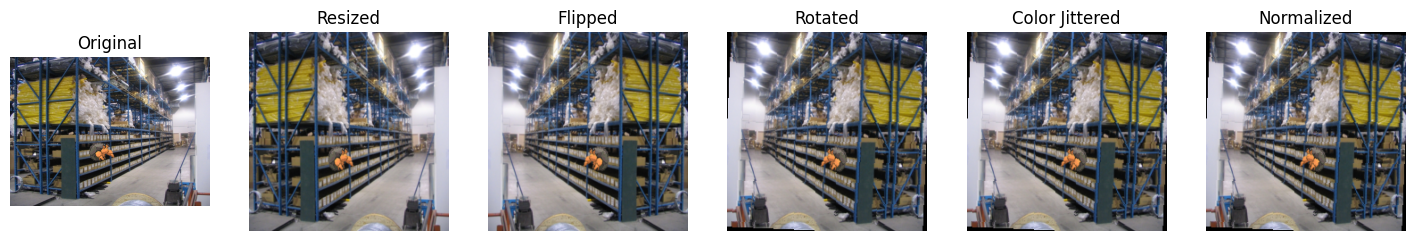

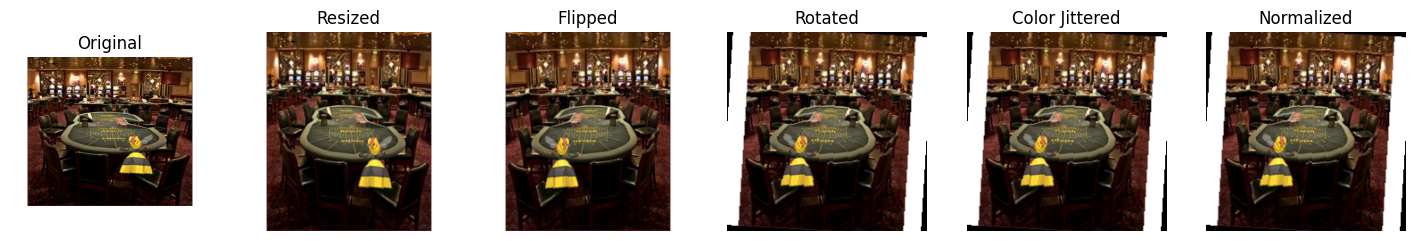

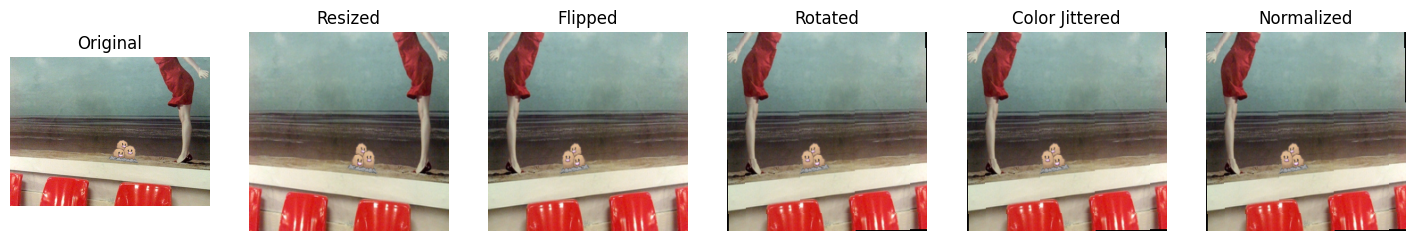

In [ ]:
# Individual step to visualize the transformations
resize = transforms.Resize((224, 224))
horizontal_flip = transforms.RandomHorizontalFlip(p=1.0)
rotation = transforms.RandomRotation(10)
color_jitter = transforms.ColorJitter()
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# To inverse the normalization for visualization
unnormalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# Random selection
images = os.listdir(image_folder)
random_indices = random.sample(range(len(images)), 3)

# Display images with transformations
for idx in random_indices:
    img_path = os.path.join(image_folder, images[idx])
    img = Image.open(img_path)

    # Apply transformations
    img_resized = resize(img)
    img_flipped = horizontal_flip(img_resized)
    img_rotated = rotation(img_flipped)
    img_jittered = color_jitter(img_rotated)
    img_tensor = to_tensor(img_jittered)
    img_normalized = normalize(img_tensor)

    # Display images
    fig, axs = plt.subplots(1, 6, figsize=(18, 6))
    axs[0].imshow(img)
    axs[0].set_title("Original")
    axs[1].imshow(img_resized)
    axs[1].set_title("Resized")
    axs[2].imshow(img_flipped)
    axs[2].set_title("Flipped")
    axs[3].imshow(img_rotated)
    axs[3].set_title("Rotated")
    axs[4].imshow(img_jittered)
    axs[4].set_title("Color Jittered")
    axs[5].imshow(unnormalize(img_normalized).permute(1, 2, 0).clip(0, 1))
    axs[5].set_title("Normalized")

    for ax in axs:
        ax.axis('off')
    plt.show()

In [ ]:
# Create datasets

# Create label-to-index mapping
unique_labels = train_df["label"].unique()
label_map = {label: Id for Id, label in enumerate(unique_labels)}

# Function to load images and labels into tensors
def load_dataset(df, img_folder, transform):
    images = []
    labels = []

    for _, row in df.iterrows():
        img_path = os.path.join(img_folder, row["Id"] + ".png")  # Construct full image path
        image = Image.open(img_path).convert("RGB")  # Open image in RGB mode
        image = transform(image)  # Apply transformations

        images.append(image)
        labels.append(label_map[row["label"]])  # Convert label to integer

    # Convert to PyTorch tensors
    images_tensor = torch.stack(images)  # Stack list of images into a single tensor
    labels_tensor = torch.tensor(labels, dtype=torch.long)  # Convert labels to tensor

    return images_tensor, labels_tensor

In [ ]:
# Load train and validation sets
train_images, train_labels = load_dataset(train_df, image_folder, train_transform)
val_images, val_labels = load_dataset(val_df, image_folder, val_transform)

In [ ]:
# Weighted Random Sampler: create a balanced training
class_counts = labels_df['encoded_label'].value_counts().to_dict()
weights = [1.0 / class_counts[label] for label in train_df['encoded_label']]
weights = torch.DoubleTensor(weights)

sampler = torch.utils.data.WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

In [ ]:
# Create TensorDataset
train_dataset = TensorDataset(train_images, train_labels)
val_dataset = TensorDataset(val_images, val_labels)

# Create dataloaders (process data in batches, reducing memory usage)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Setting up MLFlow

To execute only if you have Databricks token.

In [ ]:
# !pip install mlflow

In [ ]:
# from random import random, randint
# from mlflow import log_metric, log_param, log_artifacts
# from mlflow.tracking import MlflowClient

In [ ]:
# import mlflow
# import mlflow.pytorch

In [ ]:
# # check databricks.txt
# mlflow.login()

2025/05/14 23:19:17 INFO mlflow.utils.credentials: Successfully connected to MLflow hosted tracking server! Host: https://dbc-edfa1cca-da69.cloud.databricks.com.


In [ ]:
# mlflow.set_tracking_uri("databricks")

In [ ]:
# experiment_name = "[Put your link]/Pokemon_Classification_TransferLearning_FineTunning"

# existing_experiment = mlflow.get_experiment_by_name(experiment_name)

# if existing_experiment is None:
#     mlflow.create_experiment(
#         experiment_name,
#         artifact_location="dbfs:/Volumes/test/mlflow/Pokemon_Classification",
#     )

# mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='dbfs:/Volumes/test/mlflow/Pokemon_Classification', creation_time=1747261131099, experiment_id='3381452260219047', last_update_time=1747262999746, lifecycle_stage='active', name='/Users/hugo.werck@telecomnancy.net/Pokemon_Classification_TransferLearning_FineTunning', tags={'mlflow.experiment.sourceName': '/Users/hugo.werck@telecomnancy.net/Pokemon_Classification_TransferLearning_FineTunning',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'hugo.werck@telecomnancy.net',
 'mlflow.ownerId': '1419176588131537'}>

## 4. Transfer Learning and Fine-Tuning

In [ ]:
# Transfer learning : Use a model pretrained on a dataset A, on our dataset B. Here the dataset A is the ImageNet dataset, and the dataset B is our Pokémon dataset.

# Load pretrained model
from torchvision.models import efficientnet_b0
model = efficientnet_b0(pretrained=True)

# Freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False


# Fine-tune the last layer with an MLP
num_classes = labels_df['encoded_label'].nunique()
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


We chose EfficientNet-B0 for this classification task because it offers an excellent balance between accuracy and efficiency. Compared to older models like ResNet and VGG, EfficientNet achieves higher performance with fewer parameters, making it faster to train and less prone to overfitting on medium-sized datasets like this Pokémon dataset. Its compound scaling strategy allows it to scale depth, width, and resolution in a balanced way, which is ideal for fine-tuning on real-world images with complex backgrounds.

In [ ]:
# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Train and evaluate model

In [ ]:
# Function to compute f1 score and accuracy
from sklearn.metrics import f1_score, accuracy_score

def compute_f1(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return f1_score(all_labels, all_preds, average='weighted')

def compute_accuracy(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return accuracy_score(all_labels, all_preds)

In [ ]:
# mlflow.autolog()

# with mlflow.start_run(run_name="transfer_learning_run"):

# Training loop: It only trains the MLP part since the pretrained model is frozen.
num_epochs = 15

# Store scores
train_f1_list, val_f1_list = [], []
train_acc_list, val_acc_list = [], []

best_val_f1 = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # F1 + Acc
    train_f1 = compute_f1(model, train_loader)
    val_f1 = compute_f1(model, val_loader)
    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)

    train_f1_list.append(train_f1)
    val_f1_list.append(val_f1)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    # Step scheduler
    scheduler.step(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, "
        f"Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, "
        f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"New best model saved with Val F1: {val_f1:.4f}")

        # # MLFlow
        # mlflow.log_metric("train_loss", running_loss, step=epoch)
        # mlflow.log_metric("train_acc", train_acc, step=epoch)
        # mlflow.log_metric("val_accuracy", val_acc, step=epoch)
        # mlflow.log_metric("val_f1_score", val_f1, step=epoch)

2025/05/14 23:19:19 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/14 23:19:21 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/05/14 23:19:21 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/05/14 23:19:21 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


Epoch 1/15, Loss: 2.2011, Train F1: 0.1340, Val F1: 0.1420, Train Acc: 0.1330, Val Acc: 0.1381
New best model saved with Val F1: 0.1420
Epoch 2/15, Loss: 2.1998, Train F1: 0.1471, Val F1: 0.1535, Train Acc: 0.1476, Val Acc: 0.1548
New best model saved with Val F1: 0.1535
Epoch 3/15, Loss: 2.1886, Train F1: 0.1391, Val F1: 0.1668, Train Acc: 0.1424, Val Acc: 0.1715
New best model saved with Val F1: 0.1668
Epoch 4/15, Loss: 2.1774, Train F1: 0.1499, Val F1: 0.1709, Train Acc: 0.1602, Val Acc: 0.1841
New best model saved with Val F1: 0.1709
Epoch 5/15, Loss: 2.1681, Train F1: 0.1552, Val F1: 0.1688, Train Acc: 0.1696, Val Acc: 0.1841


In [ ]:
import matplotlib.pyplot as plt

# Graph of Accuracy
plt.figure(figsize=(8,5))
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.legend()
plt.title('Accuracy per Epoch')
plt.show()

# Graph of F1
plt.figure(figsize=(8,5))
plt.plot(train_f1_list, label='Train F1')
plt.plot(val_f1_list, label='Val F1')
plt.legend()
plt.title('F1 Score per Epoch')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Matrice
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=90, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Fine-tuning: we unfreeze all the layers of our model to train the complete model
# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Reduce learning rate: the learning rate must be way smaller the one used to train the MLP
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# experiment_name = "[Put your link]/Pokemon_Classification_FineTuning"

# existing_experiment = mlflow.get_experiment_by_name(experiment_name)

# if existing_experiment is None:
#     mlflow.create_experiment(
#         experiment_name,
#         artifact_location="dbfs:/Volumes/test/mlflow/Pokemon_Classification",
#     )

# mlflow.set_experiment(experiment_name)

In [ ]:
# mlflow.autolog()

# with mlflow.start_run(run_name="fine_tuning_run"):

# Training loop for the entire model
num_epochs = 30

#Store scores
train_f1_list, val_f1_list = [], []
train_acc_list, val_acc_list = [], []

best_val_f1 = 0.0
for epoch in range(num_epochs):
    # mlflow.autolog()
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # F1 + Acc
    train_f1 = compute_f1(model, train_loader)
    val_f1 = compute_f1(model, val_loader)
    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)

    train_f1_list.append(train_f1)
    val_f1_list.append(val_f1)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    # Step scheduler
    scheduler.step(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, "
            f"Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, "
            f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"New best model saved with Val F1: {val_f1:.4f}")

        # # MLFlow
        # mlflow.log_metric("train_loss", running_loss, step=epoch)
        # mlflow.log_metric("train_acc", train_acc, step=epoch)
        # mlflow.log_metric("val_accuracy", val_acc, step=epoch)
        # mlflow.log_metric("val_f1_score", val_f1, step=epoch)

In [ ]:
import matplotlib.pyplot as plt

# Graph of Accuracy
plt.figure(figsize=(8,5))
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.legend()
plt.title('Accuracy per Epoch')
plt.show()

# Graph of F1
plt.figure(figsize=(8,5))
plt.plot(train_f1_list, label='Train F1')
plt.plot(val_f1_list, label='Val F1')
plt.legend()
plt.title('F1 Score per Epoch')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Matrice
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=90, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

## 5. Prediction on the test data

In [ ]:
import os
from PIL import Image

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_folder = 'Test'
test_ids = []
test_preds_encoded = []

for img_name in os.listdir(test_folder):
    if img_name.endswith('.png'):
        img_id = img_name.replace('.png', '')
        test_ids.append(img_id)

        img_path = os.path.join(test_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        image = val_transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(image)
            _, pred = torch.max(outputs, 1)
            test_preds_encoded.append(pred.item())

# Uncode labels
test_preds_labels = label_encoder.inverse_transform(test_preds_encoded)

# Create submission csv
submission = pd.DataFrame({'Id': test_ids, 'label': test_preds_labels})
submission.to_csv('../submission_task3.csv', index=False)
print("Submission file created")
